### 以下是更新後的完整腳本，其中包含將四個類別轉換為0到1之間的標籤以及進行回歸任務所需的所有更改:

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from PIL import Image
from tqdm import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch.nn.functional as F


class BreastDensityDataset(ImageFolder):
    def __getitem__(self, idx):
        img_path, _ = self.imgs[idx]
        img_path = Path(img_path)
        target = float(self.classes.index(img_path.parent.name) + 1) / 4
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        return image, target



data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((1280, 1280)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
    ]),
    'valid': transforms.Compose([
        transforms.Resize((1280, 1280)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize((1280, 1280)),
        transforms.ToTensor(),
    ]),
}

data_dir = '/home/kevinluo/breast_density_classification/datasets'
datasets = {x: BreastDensityDataset(os.path.join(data_dir, x), transform=data_transforms[x]) for x in ['train', 'valid', 'test']}

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'valid', 'test']}
class_names = datasets['train'].classes

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

batch_size = 16
num_workers = 2
dataloaders = {x: DataLoader(datasets[x], batch_size=batch_size, shuffle=True, num_workers=num_workers) for x in ['train', 'valid', 'test']}

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
#         self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
#         self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
#         self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.fc1 = nn.Linear(128 * 80 * 80, 512)
#         self.fc2 = nn.Linear(512, 1)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x)))
#         x = self.pool(F.relu(self.conv4(x)))
#         x = x.view(-1, 128 * 80 * 80)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x
class ComplexNet(nn.Module):
    def __init__(self):
        super(ComplexNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(128 * 80 * 80, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout(x)
        x = x.view(-1, 128 * 80 * 80)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# model = Net()
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

model2 = ComplexNet()
#model.to(device)
model2 = ComplexNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)
num_epochs = 100

def train_model(model2, criterion, optimizer, num_epochs):
    train_losses, valid_losses, train_mse, valid_mse, train_acc, valid_acc = [], [], [], [], [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model2.train()
            else:
                model2.eval()

            running_loss = 0.0
            running_mse = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device).float()

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model2(inputs).squeeze()
                    loss = criterion(outputs, labels)
                    preds = (outputs * 4).round()
                    targets = (labels * 4)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_mse += torch.sum((outputs - labels) ** 2).cpu().item()
                running_corrects += torch.sum(preds == targets).cpu().item()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_mse = running_mse / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} MSE: {epoch_mse:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_mse.append(epoch_mse)
                train_acc.append(epoch_acc)
            else:
                valid_losses.append(epoch_loss)
                valid_mse.append(epoch_mse)
                valid_acc.append(epoch_acc)

    return model2, train_losses, valid_losses, train_mse, valid_mse, train_acc, valid_acc


In [9]:
import mlflow
from datetime import datetime
#from torchvision.models import resnet18
import numpy as np
mlflow.set_tracking_uri("http://localhost:5000/")

EXPERIMENT_NAME = "0502Regression"

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME)  # check if the experiment is already exist
if not experiment_id:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment_id.experiment_id

model = train_model
mlflow.start_run(
    experiment_id=experiment_id,
    run_name=f'test_{datetime.now().strftime("%Y-%m-%d")}',
    tags={
        "type": "test",
        "task": "mammogram"
    }
)

epochs = 100
batch_size = 16
lr = 0.001
mlflow.log_params(
    {
        "epochs": epochs,
        "batch_size": batch_size,
        "lr": lr
    }
)

AttributeError: partially initialized module 'mlflow' has no attribute 'version' (most likely due to a circular import)

In [7]:

model2, train_losses, valid_losses, train_mse, valid_mse, train_acc, valid_acc = train_model(model2, criterion, optimizer, num_epochs)
# # 记录训练和验证指标到 MLflow
# for epoch in range(num_epochs):
#     mlflow.log_metric("train_loss", train_losses[epoch], step=epoch)
#     mlflow.log_metric("valid_loss", valid_losses[epoch], step=epoch)
#     mlflow.log_metric("train_mse", train_mse[epoch], step=epoch)
#     mlflow.log_metric("valid_mse", valid_mse[epoch], step=epoch)
#     mlflow.log_metric("train_acc", train_acc[epoch], step=epoch)
#     mlflow.log_metric("valid_acc", valid_acc[epoch], step=epoch)

# # 保存模型到 MLflow
# mlflow.pytorch.log_model(model, "model")

# # 结束 MLflow 运行
# mlflow.end_run()

Epoch 1/100
----------


100%|██████████| 263/263 [03:04<00:00,  1.43it/s]


Train Loss: 0.0658 MSE: 0.0658 Acc: 0.3443


100%|██████████| 27/27 [00:18<00:00,  1.43it/s]


Valid Loss: 0.0963 MSE: 0.0963 Acc: 0.3977
Epoch 2/100
----------


100%|██████████| 263/263 [02:58<00:00,  1.47it/s]


Train Loss: 0.0547 MSE: 0.0547 Acc: 0.3759


100%|██████████| 27/27 [00:18<00:00,  1.47it/s]


Valid Loss: 0.1002 MSE: 0.1002 Acc: 0.3953
Epoch 3/100
----------


100%|██████████| 263/263 [02:56<00:00,  1.49it/s]


Train Loss: 0.0527 MSE: 0.0527 Acc: 0.3854


100%|██████████| 27/27 [00:18<00:00,  1.43it/s]


Valid Loss: 0.0917 MSE: 0.0917 Acc: 0.3977
Epoch 4/100
----------


100%|██████████| 263/263 [03:02<00:00,  1.44it/s]


Train Loss: 0.0510 MSE: 0.0510 Acc: 0.3954


100%|██████████| 27/27 [00:18<00:00,  1.44it/s]


Valid Loss: 0.0953 MSE: 0.0953 Acc: 0.3837
Epoch 5/100
----------


100%|██████████| 263/263 [03:00<00:00,  1.45it/s]


Train Loss: 0.0491 MSE: 0.0491 Acc: 0.4151


100%|██████████| 27/27 [00:18<00:00,  1.49it/s]


Valid Loss: 0.1023 MSE: 0.1023 Acc: 0.3442
Epoch 6/100
----------


100%|██████████| 263/263 [03:00<00:00,  1.46it/s]


Train Loss: 0.0477 MSE: 0.0477 Acc: 0.4144


100%|██████████| 27/27 [00:18<00:00,  1.43it/s]


Valid Loss: 0.0921 MSE: 0.0921 Acc: 0.3674
Epoch 7/100
----------


100%|██████████| 263/263 [03:03<00:00,  1.43it/s]


Train Loss: 0.0464 MSE: 0.0464 Acc: 0.4187


100%|██████████| 27/27 [00:19<00:00,  1.40it/s]


Valid Loss: 0.1076 MSE: 0.1076 Acc: 0.2930
Epoch 8/100
----------


100%|██████████| 263/263 [03:01<00:00,  1.45it/s]


Train Loss: 0.0452 MSE: 0.0452 Acc: 0.4268


100%|██████████| 27/27 [00:18<00:00,  1.44it/s]


Valid Loss: 0.1021 MSE: 0.1021 Acc: 0.3233
Epoch 9/100
----------


100%|██████████| 263/263 [02:55<00:00,  1.50it/s]


Train Loss: 0.0446 MSE: 0.0446 Acc: 0.4432


100%|██████████| 27/27 [00:17<00:00,  1.55it/s]


Valid Loss: 0.0929 MSE: 0.0929 Acc: 0.3395
Epoch 10/100
----------


100%|██████████| 263/263 [02:51<00:00,  1.54it/s]


Train Loss: 0.0439 MSE: 0.0439 Acc: 0.4396


100%|██████████| 27/27 [00:18<00:00,  1.50it/s]


Valid Loss: 0.0970 MSE: 0.0970 Acc: 0.3372
Epoch 11/100
----------


100%|██████████| 263/263 [03:04<00:00,  1.42it/s]


Train Loss: 0.0431 MSE: 0.0431 Acc: 0.4375


100%|██████████| 27/27 [00:18<00:00,  1.46it/s]


Valid Loss: 0.0955 MSE: 0.0955 Acc: 0.3465
Epoch 12/100
----------


100%|██████████| 263/263 [02:59<00:00,  1.47it/s]


Train Loss: 0.0432 MSE: 0.0432 Acc: 0.4365


100%|██████████| 27/27 [00:18<00:00,  1.45it/s]


Valid Loss: 0.0915 MSE: 0.0915 Acc: 0.3605
Epoch 13/100
----------


100%|██████████| 263/263 [03:00<00:00,  1.46it/s]


Train Loss: 0.0428 MSE: 0.0428 Acc: 0.4351


100%|██████████| 27/27 [00:17<00:00,  1.51it/s]


Valid Loss: 0.1028 MSE: 0.1028 Acc: 0.3233
Epoch 14/100
----------


100%|██████████| 263/263 [02:57<00:00,  1.49it/s]


Train Loss: 0.0425 MSE: 0.0425 Acc: 0.4398


100%|██████████| 27/27 [00:18<00:00,  1.48it/s]


Valid Loss: 0.0867 MSE: 0.0867 Acc: 0.3744
Epoch 15/100
----------


100%|██████████| 263/263 [03:03<00:00,  1.43it/s]


Train Loss: 0.0418 MSE: 0.0418 Acc: 0.4446


100%|██████████| 27/27 [00:17<00:00,  1.50it/s]


Valid Loss: 0.0936 MSE: 0.0936 Acc: 0.3558
Epoch 16/100
----------


100%|██████████| 263/263 [02:53<00:00,  1.52it/s]


Train Loss: 0.0416 MSE: 0.0416 Acc: 0.4432


100%|██████████| 27/27 [00:17<00:00,  1.51it/s]


Valid Loss: 0.0839 MSE: 0.0839 Acc: 0.3953
Epoch 17/100
----------


100%|██████████| 263/263 [03:04<00:00,  1.42it/s]


Train Loss: 0.0411 MSE: 0.0411 Acc: 0.4513


100%|██████████| 27/27 [00:18<00:00,  1.48it/s]


Valid Loss: 0.0803 MSE: 0.0803 Acc: 0.3977
Epoch 18/100
----------


100%|██████████| 263/263 [02:58<00:00,  1.47it/s]


Train Loss: 0.0408 MSE: 0.0408 Acc: 0.4463


100%|██████████| 27/27 [00:18<00:00,  1.43it/s]


Valid Loss: 0.0854 MSE: 0.0854 Acc: 0.3907
Epoch 19/100
----------


100%|██████████| 263/263 [02:59<00:00,  1.46it/s]


Train Loss: 0.0400 MSE: 0.0400 Acc: 0.4560


100%|██████████| 27/27 [00:18<00:00,  1.50it/s]


Valid Loss: 0.0832 MSE: 0.0832 Acc: 0.3907
Epoch 20/100
----------


100%|██████████| 263/263 [02:59<00:00,  1.47it/s]


Train Loss: 0.0396 MSE: 0.0396 Acc: 0.4605


100%|██████████| 27/27 [00:18<00:00,  1.47it/s]


Valid Loss: 0.0897 MSE: 0.0897 Acc: 0.3837
Epoch 21/100
----------


100%|██████████| 263/263 [03:06<00:00,  1.41it/s]


Train Loss: 0.0397 MSE: 0.0397 Acc: 0.4655


100%|██████████| 27/27 [00:19<00:00,  1.40it/s]


Valid Loss: 0.0789 MSE: 0.0789 Acc: 0.4000
Epoch 22/100
----------


100%|██████████| 263/263 [02:59<00:00,  1.46it/s]


Train Loss: 0.0392 MSE: 0.0392 Acc: 0.4629


100%|██████████| 27/27 [00:19<00:00,  1.38it/s]


Valid Loss: 0.0750 MSE: 0.0750 Acc: 0.4023
Epoch 23/100
----------


100%|██████████| 263/263 [02:52<00:00,  1.52it/s]


Train Loss: 0.0391 MSE: 0.0391 Acc: 0.4608


100%|██████████| 27/27 [00:18<00:00,  1.44it/s]


Valid Loss: 0.0761 MSE: 0.0761 Acc: 0.4047
Epoch 24/100
----------


100%|██████████| 263/263 [02:50<00:00,  1.54it/s]


Train Loss: 0.0387 MSE: 0.0387 Acc: 0.4655


100%|██████████| 27/27 [00:18<00:00,  1.48it/s]


Valid Loss: 0.0791 MSE: 0.0791 Acc: 0.4093
Epoch 25/100
----------


100%|██████████| 263/263 [02:53<00:00,  1.52it/s]


Train Loss: 0.0384 MSE: 0.0384 Acc: 0.4681


100%|██████████| 27/27 [00:18<00:00,  1.50it/s]


Valid Loss: 0.0722 MSE: 0.0722 Acc: 0.4093
Epoch 26/100
----------


100%|██████████| 263/263 [02:47<00:00,  1.57it/s]


Train Loss: 0.0381 MSE: 0.0381 Acc: 0.4727


100%|██████████| 27/27 [00:18<00:00,  1.47it/s]


Valid Loss: 0.0676 MSE: 0.0676 Acc: 0.4093
Epoch 27/100
----------


100%|██████████| 263/263 [02:58<00:00,  1.48it/s]


Train Loss: 0.0385 MSE: 0.0385 Acc: 0.4608


100%|██████████| 27/27 [00:18<00:00,  1.50it/s]


Valid Loss: 0.0817 MSE: 0.0817 Acc: 0.4070
Epoch 28/100
----------


100%|██████████| 263/263 [03:02<00:00,  1.44it/s]


Train Loss: 0.0374 MSE: 0.0374 Acc: 0.4731


100%|██████████| 27/27 [00:18<00:00,  1.46it/s]


Valid Loss: 0.0719 MSE: 0.0719 Acc: 0.4093
Epoch 29/100
----------


100%|██████████| 263/263 [02:54<00:00,  1.50it/s]


Train Loss: 0.0381 MSE: 0.0381 Acc: 0.4665


100%|██████████| 27/27 [00:18<00:00,  1.49it/s]


Valid Loss: 0.0682 MSE: 0.0682 Acc: 0.4093
Epoch 30/100
----------


100%|██████████| 263/263 [02:57<00:00,  1.48it/s]


Train Loss: 0.0371 MSE: 0.0371 Acc: 0.4715


100%|██████████| 27/27 [00:18<00:00,  1.47it/s]


Valid Loss: 0.0720 MSE: 0.0720 Acc: 0.4163
Epoch 31/100
----------


100%|██████████| 263/263 [02:57<00:00,  1.48it/s]


Train Loss: 0.0373 MSE: 0.0373 Acc: 0.4729


100%|██████████| 27/27 [00:18<00:00,  1.48it/s]


Valid Loss: 0.0768 MSE: 0.0768 Acc: 0.4116
Epoch 32/100
----------


100%|██████████| 263/263 [02:58<00:00,  1.48it/s]


Train Loss: 0.0375 MSE: 0.0375 Acc: 0.4703


100%|██████████| 27/27 [00:18<00:00,  1.43it/s]


Valid Loss: 0.0735 MSE: 0.0735 Acc: 0.4140
Epoch 33/100
----------


100%|██████████| 263/263 [03:00<00:00,  1.45it/s]


Train Loss: 0.0370 MSE: 0.0370 Acc: 0.4715


100%|██████████| 27/27 [00:17<00:00,  1.57it/s]


Valid Loss: 0.0711 MSE: 0.0711 Acc: 0.4070
Epoch 34/100
----------


100%|██████████| 263/263 [02:58<00:00,  1.48it/s]


Train Loss: 0.0372 MSE: 0.0372 Acc: 0.4722


100%|██████████| 27/27 [00:18<00:00,  1.48it/s]


Valid Loss: 0.0661 MSE: 0.0661 Acc: 0.4093
Epoch 35/100
----------


100%|██████████| 263/263 [02:54<00:00,  1.51it/s]


Train Loss: 0.0370 MSE: 0.0370 Acc: 0.4746


100%|██████████| 27/27 [00:17<00:00,  1.58it/s]


Valid Loss: 0.0702 MSE: 0.0702 Acc: 0.4140
Epoch 36/100
----------


100%|██████████| 263/263 [02:46<00:00,  1.58it/s]


Train Loss: 0.0371 MSE: 0.0371 Acc: 0.4777


100%|██████████| 27/27 [00:19<00:00,  1.39it/s]


Valid Loss: 0.0677 MSE: 0.0677 Acc: 0.4163
Epoch 37/100
----------


100%|██████████| 263/263 [02:46<00:00,  1.58it/s]


Train Loss: 0.0366 MSE: 0.0366 Acc: 0.4696


100%|██████████| 27/27 [00:17<00:00,  1.52it/s]


Valid Loss: 0.0691 MSE: 0.0691 Acc: 0.4140
Epoch 38/100
----------


100%|██████████| 263/263 [03:02<00:00,  1.44it/s]


Train Loss: 0.0363 MSE: 0.0363 Acc: 0.4824


100%|██████████| 27/27 [00:18<00:00,  1.44it/s]


Valid Loss: 0.0656 MSE: 0.0656 Acc: 0.4209
Epoch 39/100
----------


100%|██████████| 263/263 [02:56<00:00,  1.49it/s]


Train Loss: 0.0358 MSE: 0.0358 Acc: 0.4803


100%|██████████| 27/27 [00:18<00:00,  1.45it/s]


Valid Loss: 0.0684 MSE: 0.0684 Acc: 0.4209
Epoch 40/100
----------


100%|██████████| 263/263 [02:58<00:00,  1.47it/s]


Train Loss: 0.0362 MSE: 0.0362 Acc: 0.4805


100%|██████████| 27/27 [00:18<00:00,  1.47it/s]


Valid Loss: 0.0718 MSE: 0.0718 Acc: 0.4116
Epoch 41/100
----------


100%|██████████| 263/263 [03:05<00:00,  1.42it/s]


Train Loss: 0.0360 MSE: 0.0360 Acc: 0.4803


100%|██████████| 27/27 [00:17<00:00,  1.55it/s]


Valid Loss: 0.0661 MSE: 0.0661 Acc: 0.4163
Epoch 42/100
----------


100%|██████████| 263/263 [02:57<00:00,  1.48it/s]


Train Loss: 0.0360 MSE: 0.0360 Acc: 0.4803


100%|██████████| 27/27 [00:18<00:00,  1.45it/s]


Valid Loss: 0.0649 MSE: 0.0649 Acc: 0.4186
Epoch 43/100
----------


100%|██████████| 263/263 [02:45<00:00,  1.59it/s]


Train Loss: 0.0353 MSE: 0.0353 Acc: 0.4869


100%|██████████| 27/27 [00:17<00:00,  1.50it/s]


Valid Loss: 0.0727 MSE: 0.0727 Acc: 0.4163
Epoch 44/100
----------


100%|██████████| 263/263 [03:00<00:00,  1.45it/s]


Train Loss: 0.0355 MSE: 0.0355 Acc: 0.4876


100%|██████████| 27/27 [00:18<00:00,  1.46it/s]


Valid Loss: 0.0743 MSE: 0.0743 Acc: 0.4163
Epoch 45/100
----------


100%|██████████| 263/263 [02:58<00:00,  1.47it/s]


Train Loss: 0.0354 MSE: 0.0354 Acc: 0.4727


100%|██████████| 27/27 [00:18<00:00,  1.50it/s]


Valid Loss: 0.0667 MSE: 0.0667 Acc: 0.4209
Epoch 46/100
----------


100%|██████████| 263/263 [02:58<00:00,  1.47it/s]


Train Loss: 0.0355 MSE: 0.0355 Acc: 0.4860


100%|██████████| 27/27 [00:19<00:00,  1.42it/s]


Valid Loss: 0.0597 MSE: 0.0597 Acc: 0.4233
Epoch 47/100
----------


100%|██████████| 263/263 [03:03<00:00,  1.43it/s]


Train Loss: 0.0354 MSE: 0.0354 Acc: 0.4805


100%|██████████| 27/27 [00:18<00:00,  1.49it/s]


Valid Loss: 0.0684 MSE: 0.0684 Acc: 0.4233
Epoch 48/100
----------


100%|██████████| 263/263 [03:04<00:00,  1.43it/s]


Train Loss: 0.0352 MSE: 0.0352 Acc: 0.4826


100%|██████████| 27/27 [00:18<00:00,  1.44it/s]


Valid Loss: 0.0660 MSE: 0.0660 Acc: 0.4233
Epoch 49/100
----------


100%|██████████| 263/263 [02:51<00:00,  1.53it/s]


Train Loss: 0.0349 MSE: 0.0349 Acc: 0.4891


100%|██████████| 27/27 [00:18<00:00,  1.43it/s]


Valid Loss: 0.0680 MSE: 0.0680 Acc: 0.4209
Epoch 50/100
----------


100%|██████████| 263/263 [03:01<00:00,  1.45it/s]


Train Loss: 0.0350 MSE: 0.0350 Acc: 0.4876


100%|██████████| 27/27 [00:17<00:00,  1.56it/s]


Valid Loss: 0.0621 MSE: 0.0621 Acc: 0.4186
Epoch 51/100
----------


100%|██████████| 263/263 [02:48<00:00,  1.56it/s]


Train Loss: 0.0343 MSE: 0.0343 Acc: 0.4931


100%|██████████| 27/27 [00:17<00:00,  1.55it/s]


Valid Loss: 0.0596 MSE: 0.0596 Acc: 0.4233
Epoch 52/100
----------


100%|██████████| 263/263 [02:58<00:00,  1.47it/s]


Train Loss: 0.0347 MSE: 0.0347 Acc: 0.4914


100%|██████████| 27/27 [00:19<00:00,  1.41it/s]


Valid Loss: 0.0640 MSE: 0.0640 Acc: 0.4163
Epoch 53/100
----------


100%|██████████| 263/263 [03:10<00:00,  1.38it/s]


Train Loss: 0.0344 MSE: 0.0344 Acc: 0.4869


100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


Valid Loss: 0.0622 MSE: 0.0622 Acc: 0.4209
Epoch 54/100
----------


100%|██████████| 263/263 [02:45<00:00,  1.59it/s]


Train Loss: 0.0344 MSE: 0.0344 Acc: 0.4912


100%|██████████| 27/27 [00:16<00:00,  1.61it/s]


Valid Loss: 0.0655 MSE: 0.0655 Acc: 0.4209
Epoch 55/100
----------


100%|██████████| 263/263 [02:38<00:00,  1.66it/s]


Train Loss: 0.0346 MSE: 0.0346 Acc: 0.4891


100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


Valid Loss: 0.0654 MSE: 0.0654 Acc: 0.4326
Epoch 56/100
----------


100%|██████████| 263/263 [02:35<00:00,  1.69it/s]


Train Loss: 0.0345 MSE: 0.0345 Acc: 0.4872


100%|██████████| 27/27 [00:18<00:00,  1.49it/s]


Valid Loss: 0.0667 MSE: 0.0667 Acc: 0.4163
Epoch 57/100
----------


100%|██████████| 263/263 [02:43<00:00,  1.61it/s]


Train Loss: 0.0339 MSE: 0.0339 Acc: 0.4903


100%|██████████| 27/27 [00:18<00:00,  1.44it/s]


Valid Loss: 0.0642 MSE: 0.0642 Acc: 0.4233
Epoch 58/100
----------


100%|██████████| 263/263 [03:13<00:00,  1.36it/s]


Train Loss: 0.0339 MSE: 0.0339 Acc: 0.4969


100%|██████████| 27/27 [00:16<00:00,  1.59it/s]


Valid Loss: 0.0650 MSE: 0.0650 Acc: 0.4209
Epoch 59/100
----------


100%|██████████| 263/263 [02:36<00:00,  1.69it/s]


Train Loss: 0.0340 MSE: 0.0340 Acc: 0.4955


100%|██████████| 27/27 [00:20<00:00,  1.31it/s]


Valid Loss: 0.0602 MSE: 0.0602 Acc: 0.4233
Epoch 60/100
----------


100%|██████████| 263/263 [02:34<00:00,  1.70it/s]


Train Loss: 0.0339 MSE: 0.0339 Acc: 0.4960


100%|██████████| 27/27 [00:21<00:00,  1.28it/s]


Valid Loss: 0.0631 MSE: 0.0631 Acc: 0.4209
Epoch 61/100
----------


100%|██████████| 263/263 [02:39<00:00,  1.65it/s]


Train Loss: 0.0332 MSE: 0.0332 Acc: 0.4945


100%|██████████| 27/27 [00:22<00:00,  1.20it/s]


Valid Loss: 0.0560 MSE: 0.0560 Acc: 0.4256
Epoch 62/100
----------


100%|██████████| 263/263 [03:03<00:00,  1.43it/s]


Train Loss: 0.0334 MSE: 0.0334 Acc: 0.5050


100%|██████████| 27/27 [00:18<00:00,  1.44it/s]


Valid Loss: 0.0599 MSE: 0.0599 Acc: 0.4279
Epoch 63/100
----------


100%|██████████| 263/263 [02:36<00:00,  1.68it/s]


Train Loss: 0.0332 MSE: 0.0332 Acc: 0.5017


100%|██████████| 27/27 [00:20<00:00,  1.29it/s]


Valid Loss: 0.0620 MSE: 0.0620 Acc: 0.4279
Epoch 64/100
----------


100%|██████████| 263/263 [02:42<00:00,  1.61it/s]


Train Loss: 0.0333 MSE: 0.0333 Acc: 0.4922


100%|██████████| 27/27 [00:19<00:00,  1.40it/s]


Valid Loss: 0.0587 MSE: 0.0587 Acc: 0.4209
Epoch 65/100
----------


100%|██████████| 263/263 [02:31<00:00,  1.74it/s]


Train Loss: 0.0334 MSE: 0.0334 Acc: 0.4974


100%|██████████| 27/27 [00:20<00:00,  1.35it/s]


Valid Loss: 0.0678 MSE: 0.0678 Acc: 0.4186
Epoch 66/100
----------


100%|██████████| 263/263 [02:55<00:00,  1.50it/s]


Train Loss: 0.0331 MSE: 0.0331 Acc: 0.5000


100%|██████████| 27/27 [00:16<00:00,  1.60it/s]


Valid Loss: 0.0581 MSE: 0.0581 Acc: 0.4233
Epoch 67/100
----------


100%|██████████| 263/263 [02:39<00:00,  1.65it/s]


Train Loss: 0.0329 MSE: 0.0329 Acc: 0.5007


100%|██████████| 27/27 [00:20<00:00,  1.32it/s]


Valid Loss: 0.0613 MSE: 0.0613 Acc: 0.4279
Epoch 68/100
----------


100%|██████████| 263/263 [03:02<00:00,  1.44it/s]


Train Loss: 0.0331 MSE: 0.0331 Acc: 0.5002


100%|██████████| 27/27 [00:18<00:00,  1.49it/s]


Valid Loss: 0.0638 MSE: 0.0638 Acc: 0.4256
Epoch 69/100
----------


100%|██████████| 263/263 [02:34<00:00,  1.70it/s]


Train Loss: 0.0326 MSE: 0.0326 Acc: 0.5114


100%|██████████| 27/27 [00:17<00:00,  1.54it/s]


Valid Loss: 0.0612 MSE: 0.0612 Acc: 0.4233
Epoch 70/100
----------


100%|██████████| 263/263 [02:39<00:00,  1.65it/s]


Train Loss: 0.0327 MSE: 0.0327 Acc: 0.5088


100%|██████████| 27/27 [00:19<00:00,  1.38it/s]


Valid Loss: 0.0577 MSE: 0.0577 Acc: 0.4302
Epoch 71/100
----------


100%|██████████| 263/263 [02:41<00:00,  1.63it/s]


Train Loss: 0.0325 MSE: 0.0325 Acc: 0.5036


100%|██████████| 27/27 [00:16<00:00,  1.59it/s]


Valid Loss: 0.0539 MSE: 0.0539 Acc: 0.4349
Epoch 72/100
----------


100%|██████████| 263/263 [02:32<00:00,  1.72it/s]


Train Loss: 0.0324 MSE: 0.0324 Acc: 0.5067


100%|██████████| 27/27 [00:17<00:00,  1.53it/s]


Valid Loss: 0.0601 MSE: 0.0601 Acc: 0.4256
Epoch 73/100
----------


100%|██████████| 263/263 [02:34<00:00,  1.70it/s]


Train Loss: 0.0324 MSE: 0.0324 Acc: 0.5007


100%|██████████| 27/27 [00:17<00:00,  1.52it/s]


Valid Loss: 0.0537 MSE: 0.0537 Acc: 0.4372
Epoch 74/100
----------


100%|██████████| 263/263 [02:34<00:00,  1.70it/s]


Train Loss: 0.0321 MSE: 0.0321 Acc: 0.5076


100%|██████████| 27/27 [00:17<00:00,  1.54it/s]


Valid Loss: 0.0605 MSE: 0.0605 Acc: 0.4209
Epoch 75/100
----------


100%|██████████| 263/263 [02:53<00:00,  1.52it/s]


Train Loss: 0.0318 MSE: 0.0318 Acc: 0.5090


100%|██████████| 27/27 [00:16<00:00,  1.61it/s]


Valid Loss: 0.0607 MSE: 0.0607 Acc: 0.4209
Epoch 76/100
----------


100%|██████████| 263/263 [02:36<00:00,  1.68it/s]


Train Loss: 0.0316 MSE: 0.0316 Acc: 0.5140


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Valid Loss: 0.0565 MSE: 0.0565 Acc: 0.4372
Epoch 77/100
----------


100%|██████████| 263/263 [03:06<00:00,  1.41it/s]


Train Loss: 0.0316 MSE: 0.0316 Acc: 0.5026


100%|██████████| 27/27 [00:18<00:00,  1.43it/s]


Valid Loss: 0.0552 MSE: 0.0552 Acc: 0.4395
Epoch 78/100
----------


100%|██████████| 263/263 [02:54<00:00,  1.51it/s]


Train Loss: 0.0315 MSE: 0.0315 Acc: 0.5126


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Valid Loss: 0.0519 MSE: 0.0519 Acc: 0.4349
Epoch 79/100
----------


100%|██████████| 263/263 [03:01<00:00,  1.45it/s]


Train Loss: 0.0311 MSE: 0.0311 Acc: 0.5157


100%|██████████| 27/27 [00:17<00:00,  1.52it/s]


Valid Loss: 0.0550 MSE: 0.0550 Acc: 0.4302
Epoch 80/100
----------


100%|██████████| 263/263 [03:09<00:00,  1.39it/s]


Train Loss: 0.0310 MSE: 0.0310 Acc: 0.5185


100%|██████████| 27/27 [00:19<00:00,  1.37it/s]


Valid Loss: 0.0559 MSE: 0.0559 Acc: 0.4349
Epoch 81/100
----------


100%|██████████| 263/263 [02:49<00:00,  1.56it/s]


Train Loss: 0.0309 MSE: 0.0309 Acc: 0.5185


100%|██████████| 27/27 [00:18<00:00,  1.45it/s]


Valid Loss: 0.0553 MSE: 0.0553 Acc: 0.4326
Epoch 82/100
----------


100%|██████████| 263/263 [02:39<00:00,  1.65it/s]


Train Loss: 0.0312 MSE: 0.0312 Acc: 0.5171


100%|██████████| 27/27 [00:18<00:00,  1.50it/s]


Valid Loss: 0.0593 MSE: 0.0593 Acc: 0.4302
Epoch 83/100
----------


100%|██████████| 263/263 [02:35<00:00,  1.70it/s]


Train Loss: 0.0309 MSE: 0.0309 Acc: 0.5204


100%|██████████| 27/27 [00:20<00:00,  1.31it/s]


Valid Loss: 0.0614 MSE: 0.0614 Acc: 0.4372
Epoch 84/100
----------


100%|██████████| 263/263 [02:38<00:00,  1.66it/s]


Train Loss: 0.0311 MSE: 0.0311 Acc: 0.5202


100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


Valid Loss: 0.0567 MSE: 0.0567 Acc: 0.4349
Epoch 85/100
----------


100%|██████████| 263/263 [02:40<00:00,  1.64it/s]


Train Loss: 0.0306 MSE: 0.0306 Acc: 0.5221


100%|██████████| 27/27 [00:17<00:00,  1.52it/s]


Valid Loss: 0.0591 MSE: 0.0591 Acc: 0.4395
Epoch 86/100
----------


100%|██████████| 263/263 [02:51<00:00,  1.53it/s]


Train Loss: 0.0306 MSE: 0.0306 Acc: 0.5273


100%|██████████| 27/27 [00:16<00:00,  1.62it/s]


Valid Loss: 0.0561 MSE: 0.0561 Acc: 0.4349
Epoch 87/100
----------


100%|██████████| 263/263 [02:38<00:00,  1.66it/s]


Train Loss: 0.0304 MSE: 0.0304 Acc: 0.5219


100%|██████████| 27/27 [00:18<00:00,  1.48it/s]


Valid Loss: 0.0530 MSE: 0.0530 Acc: 0.4465
Epoch 88/100
----------


100%|██████████| 263/263 [02:43<00:00,  1.61it/s]


Train Loss: 0.0302 MSE: 0.0302 Acc: 0.5171


100%|██████████| 27/27 [00:17<00:00,  1.55it/s]


Valid Loss: 0.0554 MSE: 0.0554 Acc: 0.4395
Epoch 89/100
----------


100%|██████████| 263/263 [02:37<00:00,  1.67it/s]


Train Loss: 0.0303 MSE: 0.0303 Acc: 0.5247


100%|██████████| 27/27 [00:17<00:00,  1.53it/s]


Valid Loss: 0.0577 MSE: 0.0577 Acc: 0.4326
Epoch 90/100
----------


100%|██████████| 263/263 [02:52<00:00,  1.52it/s]


Train Loss: 0.0303 MSE: 0.0303 Acc: 0.5221


100%|██████████| 27/27 [00:18<00:00,  1.48it/s]


Valid Loss: 0.0512 MSE: 0.0512 Acc: 0.4372
Epoch 91/100
----------


100%|██████████| 263/263 [02:44<00:00,  1.59it/s]


Train Loss: 0.0298 MSE: 0.0298 Acc: 0.5266


100%|██████████| 27/27 [00:17<00:00,  1.56it/s]


Valid Loss: 0.0556 MSE: 0.0556 Acc: 0.4372
Epoch 92/100
----------


100%|██████████| 263/263 [02:46<00:00,  1.58it/s]


Train Loss: 0.0297 MSE: 0.0297 Acc: 0.5238


100%|██████████| 27/27 [00:22<00:00,  1.21it/s]


Valid Loss: 0.0464 MSE: 0.0464 Acc: 0.4465
Epoch 93/100
----------


100%|██████████| 263/263 [02:40<00:00,  1.63it/s]


Train Loss: 0.0301 MSE: 0.0301 Acc: 0.5245


100%|██████████| 27/27 [00:16<00:00,  1.65it/s]


Valid Loss: 0.0588 MSE: 0.0588 Acc: 0.4372
Epoch 94/100
----------


100%|██████████| 263/263 [02:36<00:00,  1.69it/s]


Train Loss: 0.0298 MSE: 0.0298 Acc: 0.5254


100%|██████████| 27/27 [00:22<00:00,  1.19it/s]


Valid Loss: 0.0503 MSE: 0.0503 Acc: 0.4535
Epoch 95/100
----------


100%|██████████| 263/263 [02:42<00:00,  1.62it/s]


Train Loss: 0.0296 MSE: 0.0296 Acc: 0.5290


100%|██████████| 27/27 [00:19<00:00,  1.40it/s]


Valid Loss: 0.0498 MSE: 0.0498 Acc: 0.4512
Epoch 96/100
----------


100%|██████████| 263/263 [02:38<00:00,  1.66it/s]


Train Loss: 0.0297 MSE: 0.0297 Acc: 0.5295


100%|██████████| 27/27 [00:19<00:00,  1.38it/s]


Valid Loss: 0.0510 MSE: 0.0510 Acc: 0.4372
Epoch 97/100
----------


100%|██████████| 263/263 [02:35<00:00,  1.70it/s]


Train Loss: 0.0291 MSE: 0.0291 Acc: 0.5347


100%|██████████| 27/27 [00:18<00:00,  1.43it/s]


Valid Loss: 0.0517 MSE: 0.0517 Acc: 0.4535
Epoch 98/100
----------


100%|██████████| 263/263 [02:37<00:00,  1.67it/s]


Train Loss: 0.0294 MSE: 0.0294 Acc: 0.5309


100%|██████████| 27/27 [00:17<00:00,  1.55it/s]


Valid Loss: 0.0505 MSE: 0.0505 Acc: 0.4395
Epoch 99/100
----------


100%|██████████| 263/263 [02:38<00:00,  1.66it/s]


Train Loss: 0.0294 MSE: 0.0294 Acc: 0.5321


100%|██████████| 27/27 [00:20<00:00,  1.30it/s]


Valid Loss: 0.0550 MSE: 0.0550 Acc: 0.4512
Epoch 100/100
----------


100%|██████████| 263/263 [02:34<00:00,  1.70it/s]


Train Loss: 0.0295 MSE: 0.0295 Acc: 0.5273


100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


Valid Loss: 0.0545 MSE: 0.0545 Acc: 0.4465


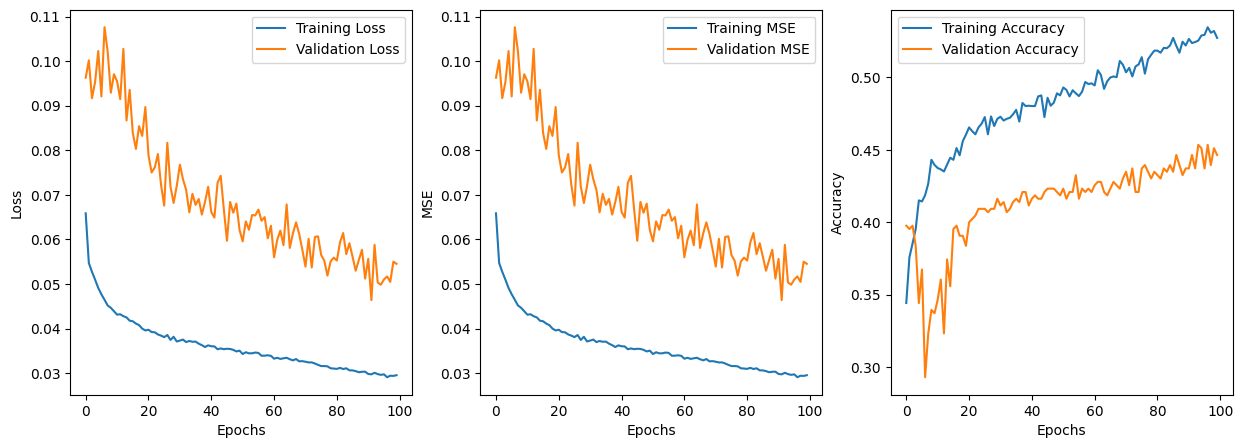

In [8]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_mse, label="Training MSE")
plt.plot(valid_mse, label="Validation MSE")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_acc, label="Training Accuracy")
plt.plot(valid_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()
